Problem Statement
Farmers every year face economic loss and crop waste due to various diseases in potato plants. Early blight and Late blight are major disease of potato leaf. It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :

Healthy leaves
Late Blight leaves
Early Blight leaves

In [ ]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [ ]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32 
CHANNELS = 3 #RGB 
EPOCHS = 20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/archive (1)/PlantVillage",
    shuffle="True",
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1920 files belonging to 3 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

60

In [ ]:
train_size = 0.8
len(dataset)*train_size

48.0

In [ ]:
train_ds = dataset.take(48)
len(train_ds)

48

In [ ]:
test_ds = dataset.skip(48)
len(test_ds)

12

In [ ]:
val_size=0.1
len(dataset)*val_size

6.0

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

48

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

6

Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architechture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric



In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
48/48 [==============================] - 203s 4s/step - loss: 0.9019 - accuracy: 0.5286 - val_loss: 0.8977 - val_accuracy: 0.4479
Epoch 2/10
48/48 [==============================] - 194s 4s/step - loss: 0.6410 - accuracy: 0.7096 - val_loss: 0.6358 - val_accuracy: 0.7552
Epoch 3/10
48/48 [==============================] - 190s 4s/step - loss: 0.4090 - accuracy: 0.8236 - val_loss: 0.5832 - val_accuracy: 0.7604
Epoch 4/10
48/48 [==============================] - 189s 4s/step - loss: 0.4132 - accuracy: 0.8229 - val_loss: 0.4357 - val_accuracy: 0.8333
Epoch 5/10
48/48 [==============================] - 189s 4s/step - loss: 0.3132 - accuracy: 0.8796 - val_loss: 0.3635 - val_accuracy: 0.8438
Epoch 6/10
48/48 [==============================] - 189s 4s/step - loss: 0.2910 - accuracy: 0.8822 - val_loss: 0.2836 - val_accuracy: 0.8854
Epoch 7/10
48/48 [==============================] - 189s 4s/step - loss: 0.2580 - accuracy: 0.8880 - val_loss: 0.2486 - val_accuracy: 0.8958
Epoch 8/10
48

In [ ]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 140s 954ms/step - loss: 1.1071 - accuracy: 0.0990


In [ ]:
scores

[1.1071195602416992, 0.0989583358168602]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 48}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

10

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9018687605857849,
 0.6409823894500732,
 0.4089685380458832,
 0.41319695115089417,
 0.31324586272239685]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: ignored

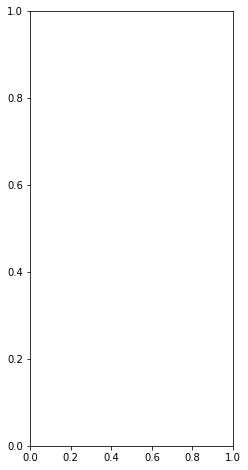

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [ ]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")